In [168]:
# https://pypi.org/project/lda/
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# http://kldavenport.com/topic-modeling-amazon-reviews/

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

# Cleaning and pre-processing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy

# Data Loading and Cleansing

In [254]:
#reviews_df = pd.read_json("../../dataset/restaurant_reviews_10k.json", lines=True)
reviews_df = pd.read_json("../../dataset/restaurant_reviews.json", lines=True)

reviews_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,--6MefnULPED_I942VcFNA,0,2017-08-17,0,4,This is one of my top 3 places to get BBQ pork...,2,FEg8v92qx3kK4Hu4TF28Fg
1,--6MefnULPED_I942VcFNA,0,2017-05-31,0,3,This restaurant is famous for their BBQ dishes...,0,HPtjvIrhzAUkKsiVkeT4MA
2,--6MefnULPED_I942VcFNA,0,2016-10-23,0,2,Roasted pork is one of my favorite things... A...,1,MpvqV7lQcl15rflTBEUhXA
3,--6MefnULPED_I942VcFNA,0,2017-07-30,0,2,I walked by the restaurant more than 5 years a...,1,x-Gbs8sVid3yhJIoHD6Gfw
4,--6MefnULPED_I942VcFNA,0,2017-02-07,1,2,I came here to order a roast duck over rice to...,0,7Dykd1HolQx8mKPYhYDYSg


In [255]:
print reviews_df.shape

(3221419, 8)


In [125]:
restaurants_df = pd.read_json("../../dataset/restaurants.json", lines=True) # Full dataset
restaurants_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,581 Howe Ave,"{u'Alcohol': u'full_bar', u'HasTV': True, u'No...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{u'Monday': u'11:00-1:00', u'Tuesday': u'11:00...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH
1,Richterstr. 11,"{u'GoodForMeal': {u'dessert': False, u'latenig...",o9eMRCWt5PkpLDE0gOPtcQ,"[Italian, Restaurants]",Stuttgart,"{u'Monday': u'18:00-0:00', u'Tuesday': u'18:00...",1,48.727200,9.147950,Messina,,70567,5,4.0,BW
2,737 West Pike St,"{u'BusinessParking': {u'garage': False, u'stre...",XOSRcvtaKc_Q5H1SAzN20A,"[Breakfast & Brunch, Gluten-Free, Coffee & Tea...",Houston,{},0,40.241548,-80.212815,East Coast Coffee,,15342,3,4.5,PA
3,600 E 4th St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",fNMVV_ZX7CJSDWQGdOM8Nw,"[Restaurants, American (Traditional)]",Charlotte,"{u'Thursday': u'7:00-15:00', u'Tuesday': u'7:0...",1,35.221647,-80.839345,Showmars Government Center,Uptown,28202,7,3.5,NC
4,2459 Yonge St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",l09JfMeQ6ynYs5MCJtrcmQ,"[Italian, French, Restaurants]",Toronto,"{u'Monday': u'9:00-22:00', u'Tuesday': u'9:00-...",0,43.711399,-79.399339,Alize Catering,Yonge and Eglinton,M4P 2H6,12,3.0,ON


In [257]:
# Cleaning and pre-processing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#doc_clean = [clean(doc) for doc in reviews_df.text]  
doc_clean = reviews_df.text

In [258]:
# Save doc so it can be retrieved later
doc_clean[0:5]

0    This is one of my top 3 places to get BBQ pork...
1    This restaurant is famous for their BBQ dishes...
2    Roasted pork is one of my favorite things... A...
3    I walked by the restaurant more than 5 years a...
4    I came here to order a roast duck over rice to...
Name: text, dtype: object

# Topic Modeling using LDA

In [259]:
def print_top_words(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        topic_names.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topic_names

In [260]:
n_features = 100000
n_topics = 100
n_top_words = 3

print "Fitting Count Vectorizer"
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(doc_clean)

print "Fitting LDA"
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)

Fitting Count Vectorizer
ERROR! Session/line number was not unique in database. History logging moved to new session 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



43
Traceback (most recent call last):
  File "/Users/ayuen/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/ayuen/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Users/ayuen/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/ayuen/anaconda2/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/ayuen/anaconda2/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/ayuen/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  F

IndexError: string index out of range

In [226]:
tf_feature_names = tf_vectorizer.get_feature_names()
topic_names = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: stirfried conos awardwinning
Topic #1: anniversary high steak
Topic #2: paneer korma shahi
Topic #3: madrid burgher sophia
Topic #4: le pour mi
Topic #5: nandini tikki tika
Topic #6: la lassi vegan
Topic #7: village oldest furnace
Topic #8: aloo evidenced detracts
Topic #9: cacciatore berto blah
Topic #10: marg lasse busing
Topic #11: intoxicated robotic fking
Topic #12: shellfish fettuccine rosa
Topic #13: bruschetta carrabas penne
Topic #14: useful joining accomodate
Topic #15: differ champaignurbana condescendingly
Topic #16: umami brendan wen
Topic #17: dish favourite place
Topic #18: prince postinos upwards
Topic #19: easier kennywood chimichanga
Topic #20: time pork service
Topic #21: tiramisu bravo piccata
Topic #22: absorbing garner economical
Topic #23: curry poutine udon
Topic #24: collard steak service
Topic #25: degree fireplace rink
Topic #26: vraiment surtout là
Topic #27: saag punjabi timethey
Topic #28: paratha ambianceespecially 1940sish
Topic #29: corridor n

# Building the Review-Topic Distribution Matrix

In [227]:
# Compute review-topic distribution vectors
# Each row represents a review's topic distribution
# Each column is the probability of the topic. The sum of all entries in a row should = 1.0 (becuase it's a distirbution)
review_topic = lda.transform(tf)
review_topic_df = pd.DataFrame(review_topic)
review_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,...,0.122631,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625
1,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,...,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500
2,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,...,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233
3,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,...,0.292118,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
4,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.087174,0.000217,0.000217,...,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217


# Visualizing Review's Topic Distribution

Review text:  This is one of my top 3 places to get BBQ pork (char siu). It is not the cheapest option, but you get what you pay for. My other go tos include Kum Hong BBQ and Skyview Fusion restaurant.
(100,)


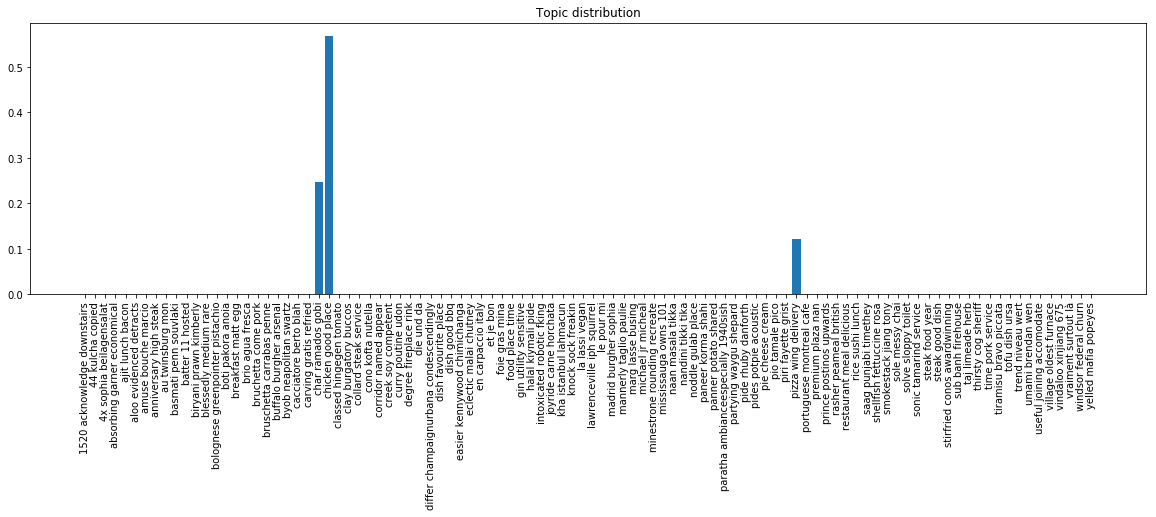

In [228]:
def display_review_topic_dist(review_id, review_topic_df):
    review_text = reviews_df.text[review_id]
    print "Review text: ", review_text
    review_dist = pd.DataFrame(review_topic_df.loc[review_id])
    review_dist.columns = ['dist']
    print review_dist.dist.shape
    
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, review_dist.dist)
    plt.plot()
    
display_review_topic_dist(0, review_topic_df)

Review text:  This restaurant is famous for their BBQ dishes and they are actually very good. It also has a variety of other non-BBQ dishes. Compare to other places that sell BBQ dishes, this restaurant is a bit pricey but their dishes are pretty good.
(100,)


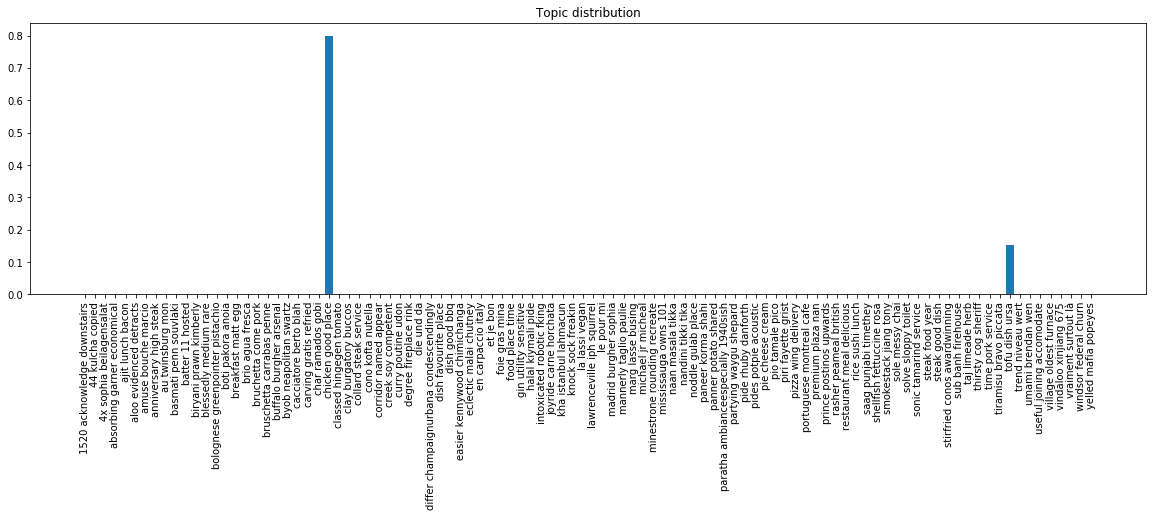

In [113]:
display_review_topic_dist(1, review_topic_df)

Review text:  Roasted pork is one of my favorite things... And we pay a premium for the meat around the ribs and the belly area because of the wonderful marbling...  beautiful layer after layer of alternating meat and fat.  My wife bought some from John's today... paid a premium for this "cut" and when I opened up the box it was all meaty pieces without marbling... Very disappointed.  The flavour was decent but not the cut we paid for.  Probably best to keep going to the BBQ place at Valleymede and HWY 7 (north side) in the plaza with McDees.
(100,)


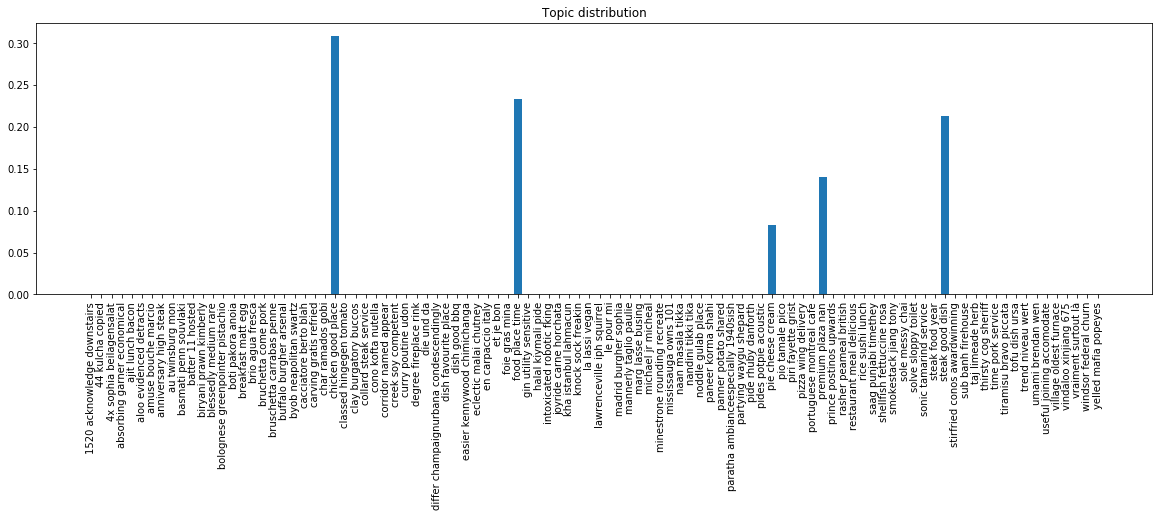

In [230]:
display_review_topic_dist(2, review_topic_df)

Review text:  I walked by the restaurant more than 5 years ago when I witnessed from the window one of the employees drop a bbq chicken wing on the floor, pick it up and place it back in the bbq meat display cabinet as if nothing happened. After that, I vowed never to come here, but after 5+ years, I figured I should try it at least once... 

I kept seeing glowing reviews here about the great char-siu wong (bbq pork king). I see comments like the best in GTA, so I had to try it out. At $28 for the made-to-order char-siu dish, I was expecting something that would be on par with the best. Sadly, I've had better bbq pork from fast food take out places (Richlane, Kum Hong BBQ, etc...). It was slightly cold, suggesting they just warmed it up. The edges were burnt, but the outer layer wasn't crispy. They put way too much honey making it too sweet. Worst of all, the pork wasn't very tender. Was quite disappointed... 

The bbq pork at Skyview fusion (Woodbine and Hwy 7) is way better. Also I w

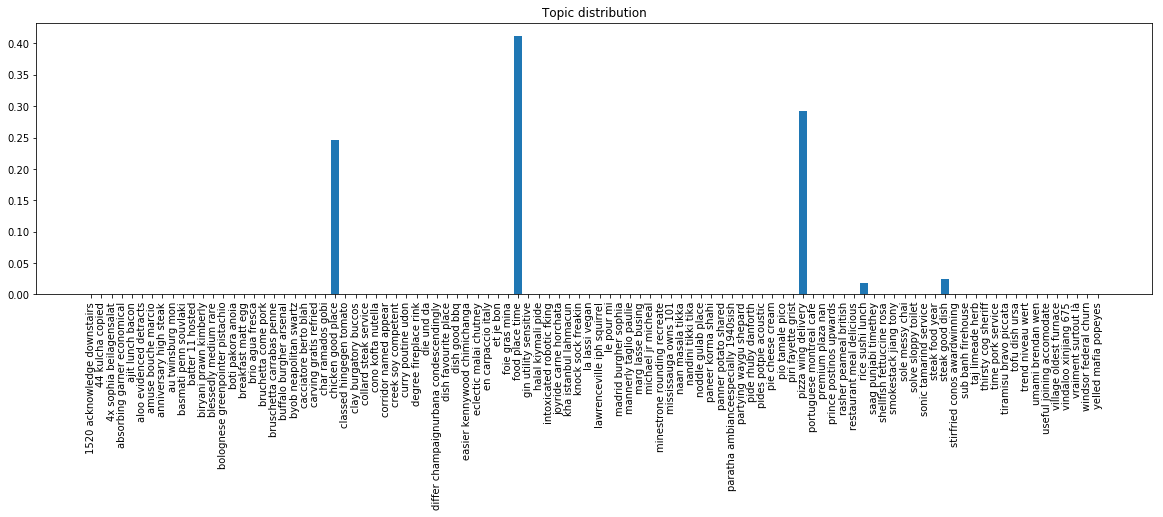

In [231]:
display_review_topic_dist(3, review_topic_df)

# Building the User Sum Rating Table

In [232]:
# Build user sum rating table
user_rating_agg_df = reviews_df.groupby('user_id')['stars'].aggregate(['sum', 'count'])
user_rating_agg_df.sort_values(by='count', ascending=False).head()

,sum,count
user_id,,
Lfv4hefW1VbvaC2gatTFWA,18,5
rCWrxuRC8_pfagpchtHp6A,12,4
-lh59ko3dxChBSZ9U7LfUw,18,4
M9TjYmTgHayJ22cNkyvW_g,16,4
0QdwQLVxZpgy9Qb2Qakflw,16,4


# Building the User-Topic Distribution Matrix

In [233]:
# 1. Iterate each user and get all the user's reviews
# 2. User A’s Topic Space = SUM( rating i / SUM rating * review i topic vector )
# 3. May want to filter out users with too little reviews, these users may not have a very representative topic distribution

user_topics = []

c = 0
for user_id in reviews_df.user_id.unique():
    user_df = reviews_df[reviews_df.user_id == user_id]
    sum_user_rating = user_rating_agg_df[user_rating_agg_df.index == user_id]['sum'][0]
    
    # Initialize user-topic distribution
    user_topic_dist = np.zeros(n_topics)
    
    for review in user_df.iterrows():
        review_id = review[0]
        rating = review[1]['stars']
        topic_dist = review_topic_df.loc[review_id]
        user_topic_dist += (rating+0.0)/sum_user_rating * topic_dist
    
    user_topics.append([user_id, user_topic_dist])

user_topics_df = pd.DataFrame(user_topics)

In [234]:
user_topics_df.columns = ['user_id', 'topic_distribution']
user_topics_df.head()

,user_id,topic_distribution
0,FEg8v92qx3kK4Hu4TF28Fg,0 0.000625 1 0.000625 2 0.000625 3...
1,HPtjvIrhzAUkKsiVkeT4MA,0 0.000500 1 0.000500 2 0.000500 3...
2,MpvqV7lQcl15rflTBEUhXA,0 0.000233 1 0.000233 2 0.000233 3...
3,x-Gbs8sVid3yhJIoHD6Gfw,0 0.000166 1 0.000166 2 0.000166 3...
4,7Dykd1HolQx8mKPYhYDYSg,0 0.000217 1 0.000217 2 0.000217 3...


In [235]:
user_topics_df.shape

(9636, 2)

# Visualizing Users's Topic Distribution

User ID:  Lfv4hefW1VbvaC2gatTFWA

Reviews:
Stopped by to have a quick lunch with a colleague who recommended. Nice place, not very crowded and good service. 

Had a special of the day: ravioli with grilled chicken. Very good red sauce and ravioli, chicken was kind of eh. It came with a thick piece of toasted Italian bread that was perfect with the meal.
Stopped by with a friend who had been  to IPH and wanted to go back. Very casual atmosphere with a big bar, long list of beers and many TV's.  
Ordered a fall special of Smoke & Fire that is a smoked brisket with a pepper cheese (forgot the name) and an onion ring with hand cut fries.  The brisket comes on a bun that is large and very good.  It definitely had some of the smoke flavor and some spiciness from the cheese.  We definitely enjoyed our food.  The Smoke & Fire "Handheld" sandwich cost $16.  Thought it to be good but the price seems to be a bit high, guess you are paying for the ambiance.

Oh, Yea, the WIFI sucks.  Did not work 

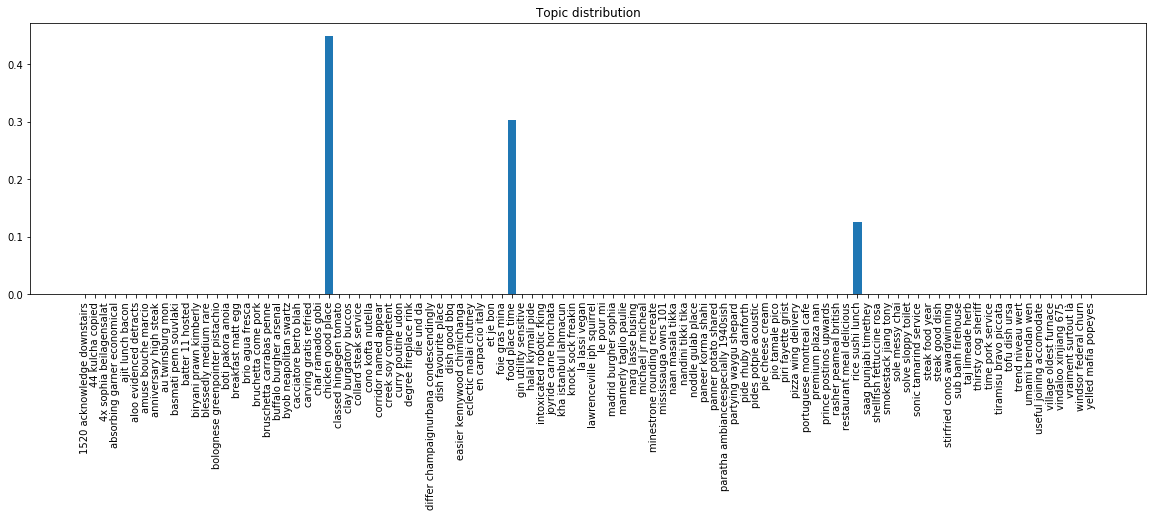

In [236]:
def display_user_topic_dist(user_id, user_topics_df):
    print "User ID: ", user_id
    print ""
    
    print "Reviews:"
    for r in reviews_df[reviews_df.user_id == user_id].iterrows():
        print r[1].text
    
    topic_dist = user_topics_df.loc[review_id]

    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, topic_dist)
    plt.plot()
    
display_user_topic_dist('Lfv4hefW1VbvaC2gatTFWA', review_topic_df)

# Build Recommender

In [237]:
# Uses symmetric Kullback–Leibler divergence
def latent_topic_similarity(user_topic_1, user_topic_2):
    return entropy(user_topic_1, user_topic_2)

In [238]:
# For a given user_id, finds the top k nearest neighbors excluding that user
def find_nn(user_id, user_topics_df, k=10):
    user_topic_dist = user_topics_df[user_topics_df.user_id == user_id].topic_distribution.iloc[0]
    
    nn_list = []
    for r in user_topics_df.iterrows():
        other_user_id = r[1].user_id
        other_topic_dist = r[1].topic_distribution
        similarity_score = latent_topic_similarity(user_topic_dist, other_topic_dist)
        
        nn_list.append([other_user_id, similarity_score])
        
    nn_df = pd.DataFrame(nn_list)
    nn_df.columns = ['user_id', 'similarity_score']
        
    # Removes the original user
    return nn_df[nn_df.user_id != user_id].sort_values(by='similarity_score', ascending=True)[:10]

find_nn('Lfv4hefW1VbvaC2gatTFWA', user_topics_df, 10)

,user_id,similarity_score
8190,VzjWvXlKfM_QYV-SPS25lw,0.151358
8568,UMmxnATEraF1qUZQLdeL-w,0.163321
1655,p7VESlDGmZpTP1Yck52Seg,0.185882
2585,bhJ6ivAuSpgXP4JiKWjSZQ,0.196249
3886,62JJoUPxKxqb6snMJxi2ng,0.197277
1709,ip1uOf1q_yDwmA-QpjXcbg,0.221748
2238,UBUV0ElEvm8kgxZvcdDo2Q,0.230074
5173,5UYjT5YDKSuApFax2t2eqg,0.249034
8201,xSiaSnRfXBVZstO9LBNRaA,0.261326
1839,qUL3CdRRF1vedNvaq06rIA,0.274354


In [253]:
def find_recommendations(user_id, n_restaurants=10):
    reviewed_business_ids = reviews_df[reviews_df.user_id == user_id].business_id
    nn_user_ids = find_nn(user_id, user_topics_df, 10)
    nn_user_ids = nn_user_ids.set_index('user_id')
    
    # Only recommend positive reviews
    pos_df = reviews_df[reviews_df.stars >= 4] 
    
    # Only recommend from nearest neighbors
    pos_df = pos_df.set_index('user_id')
    recommendations_df = pos_df.join(nn_user_ids, how='inner').sort_values(by='stars', ascending=False)
    
    # Remove recommendations where user has already given a review (e.g. has been to the restaurant)
    pos_df = pos_df.join(reviewed_business_ids, how='left', on='business_id', rsuffix='_r')
    pos_df = pos_df[pd.isnull(pos_df.business_id_r)]
    
    recommendations_df['recommendation_score'] = (6 - recommendations_df.stars) * recommendations_df.similarity_score
    return recommendations_df.sort_values(by='recommendation_score')

# The lower recommendation_score the better
find_recommendations('Lfv4hefW1VbvaC2gatTFWA')

,business_id,cool,date,funny,stars,text,useful,similarity_score,recommendation_score
user_id,,,,,,,,,
p7VESlDGmZpTP1Yck52Seg,-8F04F54iDT6VgWPCgybug,0,2017-11-22,0,5,OMG I LOVED THIS PLACE!!! As soon as I walked ...,0,0.185882,0.185882
bhJ6ivAuSpgXP4JiKWjSZQ,-8QlV3b_9H4BAh6LgMIr1g,0,2014-07-24,0,5,YUM! The best Indian food I have ever had. S...,0,0.196249,0.196249
VzjWvXlKfM_QYV-SPS25lw,-7H-oXvCxJzuT42ky6Db0g,1,2014-10-31,0,4,We stopped by here while out in Lawrenceville ...,1,0.151358,0.302716
UMmxnATEraF1qUZQLdeL-w,-7PX_FOoCwktlunImRyZdg,0,2016-06-17,0,4,Friendly & quick service. The pizza was delici...,1,0.163321,0.326643
p7VESlDGmZpTP1Yck52Seg,--I7YYLada0tSLkORTHb5Q,0,2017-10-02,0,4,This place is a sports bar atmosphere with som...,0,0.185882,0.371765
UBUV0ElEvm8kgxZvcdDo2Q,--ujyvoQlwVoBgMYtADiLA,0,2015-05-31,0,4,What else can you say about a Primanti's sandw...,0,0.230074,0.460149
UBUV0ElEvm8kgxZvcdDo2Q,-7H-oXvCxJzuT42ky6Db0g,0,2014-09-28,0,4,I've been here quite a few times for different...,0,0.230074,0.460149
5UYjT5YDKSuApFax2t2eqg,-6tvduBzjLI1ISfs3F_qTg,7,2015-09-13,1,4,"K and I visited this place a long time ago, a...",7,0.249034,0.498069
xSiaSnRfXBVZstO9LBNRaA,-7H-oXvCxJzuT42ky6Db0g,0,2015-07-04,0,4,"A very pleasant bar experience, with good bar ...",0,0.261326,0.522652


# Next Steps

In [172]:
# filtering users with little reviews